In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
NOISE_DIM = 128 # 64 in Gitlab
TESTING= False
BATCH_SIZE = 64
SAMPLE_SIZE= 50000
BINS = 25

In [3]:
filenames = {
    "herwig": "../GAN-data/events_anomalydetection_DelphesHerwig_qcd_features.h5",
    "pythiabg": "../GAN-data/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "../GAN-data/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]

train_features = ["ptj1", "etaj1", "mj1", "ptj2", "etaj2", "phij2", "mj2", "tau21j1", "tau21j2"]
condition_features = ["mjj"]

features = train_features + condition_features
GEN_DIM = NOISE_DIM + len(condition_features)
DISC_DIM = len(features)

In [4]:
def cut_data(uncut_data, pTmin = 1200, etamax = 2.5):
    # Column 0: ptj1
    # Column 1: etaj1
    # Column 3: ptj2
    # Column 4: etaj2
    return uncut_data[((uncut_data[:,0] > pTmin) & (np.abs(uncut_data[:,1]) < etamax)) | ((uncut_data[:,3] > pTmin) & (np.abs(uncut_data[:,4]) < etamax))]

np_bg_SB = np.load('./data/processed/np_bg_SB_2.npy')
np_bg_SR = np.load('./data/train_bg.npy')
np_sig_SR = np.load('./data/train_sig.npy')
test_data = np.load('./data/test_data.npy')


np_sig_SR_labeled = np.copy(np_sig_SR)
np_bg_SR_labeled = np.copy(np_bg_SR)
#add sb label
np_sig_SR_labeled = np.append(np_sig_SR_labeled,np.ones([len(np_sig_SR),1]),1)
np_bg_SR_labeled = np.append(np_bg_SR_labeled,np.zeros([len(np_bg_SR),1]),1)

np_combined_SR = np.concatenate((np_bg_SR, np_sig_SR), axis = 0)
np_combined_SR_labeled = np.concatenate((np_sig_SR_labeled,np_bg_SR_labeled),axis=0)

gc.collect()

12

In [5]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      
]
def classifier_model():    
    model = tf.keras.Sequential()
    model.add(layers.Dense(64,input_dim = 4,activation ='relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(64,activation = 'relu'))
    model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=[METRICS])
    return model

def learningCurveLoss(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    #plt.ylim(0,5)
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    plt.savefig('5_tag_learning_curve.png')
    plt.show()
    plt.close()
    #plt.savefig("Learning_Curve")
def plot_roc_curve(y_test, y_test_score):

    fpr, tpr, _ = roc_curve(y_test, y_test_score)
    auc_value = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr,label=' AUC = %.1f%%'%(auc_value*100.))
    plt.plot([0, 1], [0, 1], 'k-')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc='lower right')
    plt.show()


In [6]:
def generate_gan(generator, realdata):

    labels = sample_fake(refdata = realdata, size = SAMPLE_SIZE) # Sample mjj from the existing distribution of mjj for comparison
    labels_scaled = scaler_mjj.transform(labels.reshape(-1,1))
    fakedata_uncut_unscaled = generator(tf.concat([tf.random.uniform((SAMPLE_SIZE, NOISE_DIM)), labels_scaled], 1), training=False)
    fakedata_uncut = np.concatenate((scaler.inverse_transform(fakedata_uncut_unscaled), labels.reshape(-1,1)), axis = 1)

    # At least one jet has pT > 1200 and |eta| < 2.5
    fakedata = cut_data(fakedata_uncut)
    # mjj = sqrt(Ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)
    fakedata_mjj = mjj(fakedata)
    return fakedata
def mjj(output):
    pt1 = output[:,0]
    eta1 = output[:,1]
    m1 = output[:,2]
    pt2 = output[:,3]
    eta2 = output[:,4]
    phi2 = output[:,5]
    m2 = output[:,6]
    ejj = np.sqrt((pt1 * np.cosh(eta1))**2 + m1**2) + np.sqrt((pt2 * np.cosh(eta2))**2 + m2**2)
    pxjj = pt1 + pt2 * np.cos(phi2)
    pyjj = pt2 * np.sin(phi2)
    pzjj = pt1 * np.sinh(eta1) + pt2 * np.sinh(eta2)
    return np.sqrt(ejj**2 - pxjj**2 - pyjj**2 - pzjj**2)
def sample_fake(refdata = np_combined_SR, size = BATCH_SIZE):
    rand_idx = np.random.choice(refdata.shape[0], size = size)
    return refdata[rand_idx, -1].reshape((-1,1))
def sample_data(refdata = np_combined_SR_labeled,size= 10000):
    rand_idx = np.random.choice(refdata.shape[0], size)
    return refdata[rand_idx, :]


In [7]:
np_bg_SB_trimmed = np.delete(np_bg_SB, [i for i in range(np_bg_SB.shape[0] % (BATCH_SIZE * 4))], axis = 0)

# Normalize inputs between -1 and 1, mjj between 0 and 1
scaler = MinMaxScaler((-1,1)).fit(np_bg_SB_trimmed[:,:-1])
scaler_mjj = MinMaxScaler((0,1)).fit(np_bg_SB_trimmed[:,-1].reshape(-1,1))
np_bg_SB_scaled = np.concatenate((scaler.transform(np_bg_SB_trimmed[:,:-1]), scaler_mjj.transform(np_bg_SB_trimmed[:,-1].reshape(-1,1))), axis = 1)

In [8]:
gen_model = tf.keras.models.load_model('./Results/epoch1000-generator.h5')

In [9]:
classifier = classifier_model()
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4

In [10]:
#np_sig_SR_labeled = np.copy(np_sig_SR)
#np_bg_SR_labeled = np.copy(np_bg_SR)
sig_SR = sample_data(np_sig_SR,50000)
bg_SR = sample_data(np_bg_SR,50000)
sampleA = np.concatenate((sig_SR,bg_SR),axis=0) #real data
sampleA = np.concatenate((sampleA,np.ones([len(sampleA),1])),axis=1) #put label 1 for real



In [11]:
real_df = pd.DataFrame(sampleA , columns =['pt1','eta1','m1','pt2','eta2','phi2','m2','tau21j1','tau21j2','tau32j1','tau32j2','mjj','sb','rf'])

In [12]:
real_df

,pt1,eta1,m1,pt2,eta2,phi2,m2,tau21j1,tau21j2,tau32j1,tau32j2,mjj,sb,rf
0,1742.673462,-0.362963,500.854004,1739.793823,0.069427,3.146466,163.031006,0.169174,0.375697,0.646732,0.703927,3638.843750,1.0,1.0
1,1503.048584,0.505310,486.255005,1456.663452,-0.391913,3.166634,102.371002,0.075776,0.594301,0.733773,0.406810,3333.651367,1.0,1.0
2,1758.711914,0.208771,111.254997,1579.172119,-0.224170,3.170139,234.957001,0.424410,0.622030,0.574750,0.794624,3431.548584,1.0,1.0
3,1740.507324,0.051597,94.332397,1478.874146,-0.496545,3.331101,517.788025,0.423560,0.148712,0.828594,0.630489,3399.530518,1.0,1.0
4,1474.173096,0.630289,105.570999,1405.658936,-0.737401,3.139649,539.083008,0.274782,0.270636,0.460859,0.734623,3660.812988,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1201.547974,-0.600605,105.714996,809.897583,1.615417,3.301625,79.383003,0.687875,0.784337,0.727695,0.648119,3315.145020,0.0,1.0
99996,1456.376953,0.642232,50.279701,1433.181763,-0.699362,3.126412,456.768005,0.657911,0.201732,0.607193,0.750441,3622.067383,0.0,1.0
99997,1248.057373,1.078713,77.419403,1050.399048,-0.759129,3.262095,285.082001,0.704604,0.309067,0.695051,0.802123,3355.587158,0.0,1.0
99998,1656.099609,-0.475807,117.887001,1586.581665,0.139127,3.097388,498.040009,0.454033,0.153719,0.761067,0.665450,3476.243652,0.0,1.0


In [13]:
real_forGen = real_df.drop(['tau32j1', 'tau32j2'], axis=1)

In [14]:
real_forGen

,pt1,eta1,m1,pt2,eta2,phi2,m2,tau21j1,tau21j2,mjj,sb,rf
0,1742.673462,-0.362963,500.854004,1739.793823,0.069427,3.146466,163.031006,0.169174,0.375697,3638.843750,1.0,1.0
1,1503.048584,0.505310,486.255005,1456.663452,-0.391913,3.166634,102.371002,0.075776,0.594301,3333.651367,1.0,1.0
2,1758.711914,0.208771,111.254997,1579.172119,-0.224170,3.170139,234.957001,0.424410,0.622030,3431.548584,1.0,1.0
3,1740.507324,0.051597,94.332397,1478.874146,-0.496545,3.331101,517.788025,0.423560,0.148712,3399.530518,1.0,1.0
4,1474.173096,0.630289,105.570999,1405.658936,-0.737401,3.139649,539.083008,0.274782,0.270636,3660.812988,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1201.547974,-0.600605,105.714996,809.897583,1.615417,3.301625,79.383003,0.687875,0.784337,3315.145020,0.0,1.0
99996,1456.376953,0.642232,50.279701,1433.181763,-0.699362,3.126412,456.768005,0.657911,0.201732,3622.067383,0.0,1.0
99997,1248.057373,1.078713,77.419403,1050.399048,-0.759129,3.262095,285.082001,0.704604,0.309067,3355.587158,0.0,1.0
99998,1656.099609,-0.475807,117.887001,1586.581665,0.139127,3.097388,498.040009,0.454033,0.153719,3476.243652,0.0,1.0


In [15]:
realG= real_forGen.to_numpy()

In [16]:
generated_data = generate_gan(gen_model,realG[:,0:10])
generated_data2 = generate_gan(gen_model,realG[:,0:10])
generated_data = np.concatenate((generated_data,generated_data2), axis = 0)
generated_data_labeled  = np.copy(generated_data)
generated_data_labeled = np.append(generated_data_labeled,np.zeros([len(generated_data_labeled),1]),1)

In [17]:
gend_df = pd.DataFrame(generated_data_labeled, columns = ['pt1','eta1','m1','pt2','eta2','phi2','m2','tau21j1','tau21j2','mjj','sb'])

In [18]:
gend_df

,pt1,eta1,m1,pt2,eta2,phi2,m2,tau21j1,tau21j2,mjj,sb
0,1532.170495,0.465776,96.921012,1418.995523,-0.713779,3.163234,109.177846,0.565680,0.339698,3365.409912,0.0
1,1540.518487,-0.412763,760.584055,1547.955101,0.652782,3.164532,93.507623,0.202398,0.630253,3534.004639,0.0
2,1545.096565,0.471130,191.721173,1365.050575,-0.781354,3.186425,185.542311,0.518546,0.554099,3402.024658,0.0
3,1451.857451,-0.491709,117.887820,1396.648163,0.811574,3.157554,268.259047,0.732887,0.201504,3380.277344,0.0
4,1742.573679,0.231312,437.375952,1750.432392,0.311940,3.153340,11.446677,0.804840,0.923289,3392.537598,0.0
...,...,...,...,...,...,...,...,...,...,...,...
99995,1407.254907,-0.728827,225.840227,990.917718,1.119308,3.203920,240.134677,0.290111,0.586248,3383.114502,0.0
99996,1585.856987,0.967001,104.714643,1476.488217,-0.288973,3.178489,108.674998,0.695214,0.880701,3589.883789,0.0
99997,1334.460322,-1.018228,485.140631,1062.289335,0.723800,3.067835,131.409729,0.235044,0.553480,3303.843506,0.0
99998,1778.370400,0.169246,592.046023,1824.220839,0.080596,3.162747,510.641381,0.167213,0.485508,3637.097900,0.0


In [19]:
sampleB= sample_data(generated_data_labeled,100000) # generated data
sampleB = np.concatenate((sampleB,np.zeros([len(sampleB),1])),axis=1)

In [20]:
gen_df = pd.DataFrame(sampleB, columns = ['pt1','eta1','m1','pt2','eta2','phi2','m2','tau21j1','tau21j2','mjj','sb','rf'])

In [21]:
gen_df

,pt1,eta1,m1,pt2,eta2,phi2,m2,tau21j1,tau21j2,mjj,sb,rf
0,1739.259874,-0.308414,114.418417,1588.494734,-0.865976,3.117396,356.450307,0.371316,0.561004,3335.309570,0.0,0.0
1,1584.818743,-0.307554,370.351579,1512.943070,-1.227947,3.163787,348.961871,0.572285,0.322731,3350.596191,0.0,0.0
2,1635.947405,-1.298633,116.756630,1634.591207,-0.306653,3.146597,48.540050,0.765977,0.847091,3592.152588,0.0,0.0
3,1227.258011,0.860364,199.062436,1141.275339,-1.039055,3.139335,408.167558,0.897410,0.147905,3559.752441,0.0,0.0
4,1868.168075,0.304477,64.933681,1698.827055,-0.042750,3.110487,655.412723,0.805045,0.274955,3558.949463,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1608.464574,-0.690152,224.196235,1575.317426,0.358689,3.125631,77.246366,0.716546,0.847526,3541.700439,0.0,0.0
99996,1588.179383,0.509888,153.758812,1570.612252,-0.653208,3.128821,122.121776,0.748991,0.605543,3615.812500,0.0,0.0
99997,1298.854620,1.457293,311.868588,907.362136,-0.650382,2.898390,209.179960,0.891152,0.739489,3488.391602,0.0,0.0
99998,1460.171504,-1.012968,118.757193,1449.370217,0.257427,3.135450,557.848950,0.545374,0.354958,3481.509521,0.0,0.0


In [22]:
unique, counts = np.unique(sampleB[:,-1], return_counts=True)
print(dict(zip(unique, counts)))

{0.0: 100000}


In [50]:

fpr_list = []
tpr_list = []
threshold_list = []
auc_list = []
def train(s,b):
    sig_SR = sample_data(np_sig_SR,s)
    bg_SR = sample_data(np_bg_SR,b)
    sampleA = np.concatenate((sig_SR,bg_SR),axis=0) #real data
    sampleA = np.concatenate((sampleA,np.ones([len(sampleA),1])),axis=1) #put label 1 for real

    real_df = pd.DataFrame(sampleA , columns =['pt1','eta1','m1','pt2','eta2','phi2','m2','tau21j1','tau21j2','tau32j1','tau32j2','mjj','sb','rf'])
    real_forGen = real_df.drop(['tau32j1', 'tau32j2'], axis=1)
    realG= real_forGen.to_numpy()
    print(realG.shape)
    generated_data = generate_gan(gen_model,realG[:,0:10])
    generated_data2 = generate_gan(gen_model,realG[:,0:10])
    generated_data = np.concatenate((generated_data,generated_data2), axis = 0)
    generated_data_labeled  = np.copy(generated_data)
    generated_data_labeled = np.append(generated_data_labeled,np.zeros([len(generated_data_labeled),1]),1)
    sampleB= sample_data(generated_data_labeled,s+b) # generated data
    sampleB = np.concatenate((sampleB,np.zeros([len(sampleB),1])),axis=1)
    dataset = np.concatenate((realG,sampleB),axis=0)
    x_train,x_val,y_train,y_val= train_test_split(dataset[:,[2,6,7,8]],dataset[:,-1], test_size = 0.2, random_state=1) #rf label
    x_test,y_test = test_data[:,[2,6,7,8]],test_data[:,-1] #sb label

    classifier = classifier_model()
    history = classifier.fit(x_train, y_train, epochs=10, batch_size=128,validation_data=(x_val,y_val))
    learningCurveLoss(history)
    y_pred = classifier.predict(x_test) #predict on signal vs background in test sample
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_value = auc(fpr,tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    threshold_list.append(thresholds)
    auc_list.append(auc_value)
    plot_roc_curve(y_test, y_pred)
    

(100000, 12)
Train on 160000 samples, validate on 40000 samples
Epoch 1/10
160000/160000 [==============================] - 6s 35us/sample - loss: 0.7479 - tp: 42715.0000 - fp: 29547.0000 - tn: 50665.0000 - fn: 37073.0000 - accuracy: 0.5836 - precision: 0.5911 - recall: 0.5354 - auc: 0.5983 - val_loss: 0.6587 - val_tp: 10386.0000 - val_fp: 4070.0000 - val_tn: 15718.0000 - val_fn: 9826.0000 - val_accuracy: 0.6526 - val_precision: 0.7185 - val_recall: 0.5139 - val_auc: 0.6643
Epoch 2/10
160000/160000 [==============================] - 4s 26us/sample - loss: 0.6530 - tp: 42435.0000 - fp: 21667.0000 - tn: 58545.0000 - fn: 37353.0000 - accuracy: 0.6311 - precision: 0.6620 - recall: 0.5318 - auc: 0.6595 - val_loss: 0.6286 - val_tp: 10352.0000 - val_fp: 3924.0000 - val_tn: 15864.0000 - val_fn: 9860.0000 - val_accuracy: 0.6554 - val_precision: 0.7251 - val_recall: 0.5122 - val_auc: 0.6900
Epoch 3/10
160000/160000 [==============================] - 4s 26us/sample - loss: 0.6383 - tp: 40031.0000

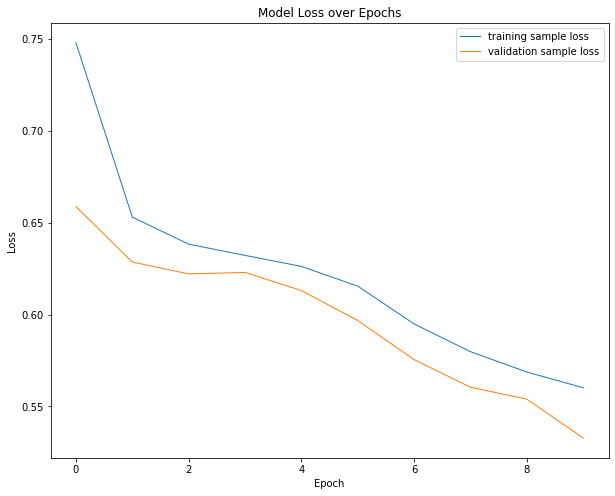

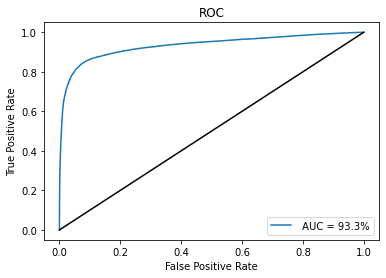

In [51]:
#sb = 1
train(50000,50000)

(95000, 12)
Train on 152000 samples, validate on 38000 samples
Epoch 1/10
152000/152000 [==============================] - 6s 39us/sample - loss: 0.8853 - tp: 40727.0000 - fp: 32567.0000 - tn: 43521.0000 - fn: 35185.0000 - accuracy: 0.5543 - precision: 0.5557 - recall: 0.5365 - auc: 0.5625 - val_loss: 0.6625 - val_tp: 11241.0000 - val_fp: 6466.0000 - val_tn: 12446.0000 - val_fn: 7847.0000 - val_accuracy: 0.6233 - val_precision: 0.6348 - val_recall: 0.5889 - val_auc: 0.6456
Epoch 2/10
152000/152000 [==============================] - 4s 28us/sample - loss: 0.6702 - tp: 41081.0000 - fp: 24895.0000 - tn: 51193.0000 - fn: 34831.0000 - accuracy: 0.6071 - precision: 0.6227 - recall: 0.5412 - auc: 0.6286 - val_loss: 0.6587 - val_tp: 10399.0000 - val_fp: 5263.0000 - val_tn: 13649.0000 - val_fn: 8689.0000 - val_accuracy: 0.6328 - val_precision: 0.6640 - val_recall: 0.5448 - val_auc: 0.6518
Epoch 3/10
152000/152000 [==============================] - 4s 28us/sample - loss: 0.6571 - tp: 39489.0000 

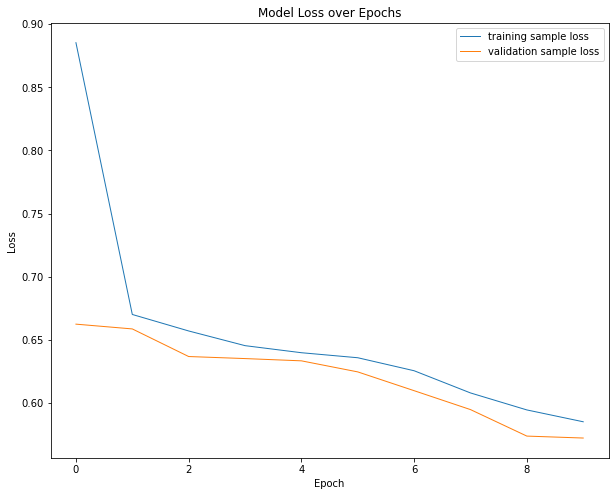

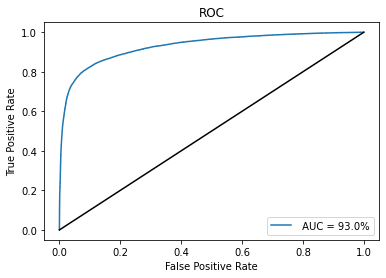

In [52]:
#sb = .9
train(45000,50000)

(99000, 12)
Train on 158400 samples, validate on 39600 samples
Epoch 1/10
158400/158400 [==============================] - 6s 38us/sample - loss: 0.8455 - tp: 33056.0000 - fp: 25029.0000 - tn: 54402.0000 - fn: 45913.0000 - accuracy: 0.5521 - precision: 0.5691 - recall: 0.4186 - auc: 0.5622 - val_loss: 0.6695 - val_tp: 5878.0000 - val_fp: 2798.0000 - val_tn: 16771.0000 - val_fn: 14153.0000 - val_accuracy: 0.5719 - val_precision: 0.6775 - val_recall: 0.2934 - val_auc: 0.6300
Epoch 2/10
158400/158400 [==============================] - 4s 28us/sample - loss: 0.6728 - tp: 28444.0000 - fp: 16254.0000 - tn: 63177.0000 - fn: 50525.0000 - accuracy: 0.5784 - precision: 0.6364 - recall: 0.3602 - auc: 0.6103 - val_loss: 0.6592 - val_tp: 5675.0000 - val_fp: 2538.0000 - val_tn: 17031.0000 - val_fn: 14356.0000 - val_accuracy: 0.5734 - val_precision: 0.6910 - val_recall: 0.2833 - val_auc: 0.6391
Epoch 3/10
158400/158400 [==============================] - 4s 28us/sample - loss: 0.6576 - tp: 36910.0000 

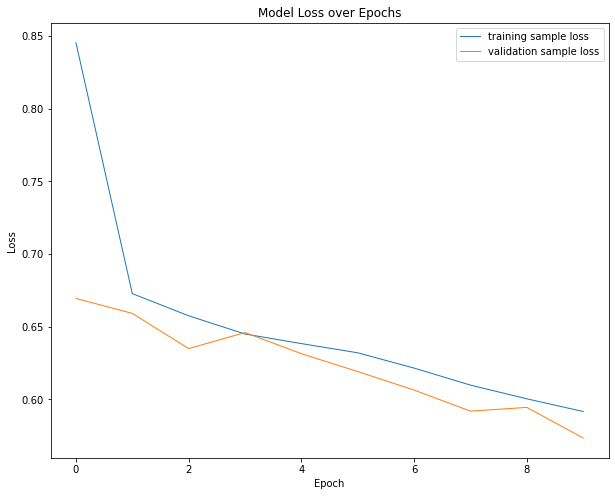

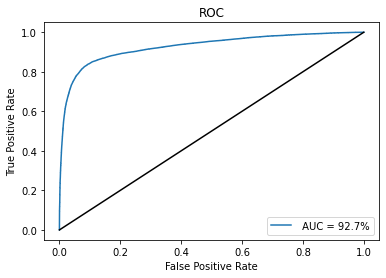

In [53]:
#sb = .8
train(44000,55000)

(119000, 12)
Train on 190400 samples, validate on 47600 samples
Epoch 1/10
190400/190400 [==============================] - 7s 38us/sample - loss: 0.7719 - tp: 46395.0000 - fp: 34121.0000 - tn: 61308.0000 - fn: 48576.0000 - accuracy: 0.5657 - precision: 0.5762 - recall: 0.4885 - auc: 0.5747 - val_loss: 0.6710 - val_tp: 12864.0000 - val_fp: 7181.0000 - val_tn: 16390.0000 - val_fn: 11165.0000 - val_accuracy: 0.6146 - val_precision: 0.6418 - val_recall: 0.5354 - val_auc: 0.6352
Epoch 2/10
190400/190400 [==============================] - 5s 28us/sample - loss: 0.6698 - tp: 44800.0000 - fp: 25756.0000 - tn: 69673.0000 - fn: 50171.0000 - accuracy: 0.6012 - precision: 0.6350 - recall: 0.4717 - auc: 0.6229 - val_loss: 0.6495 - val_tp: 12219.0000 - val_fp: 6138.0000 - val_tn: 17433.0000 - val_fn: 11810.0000 - val_accuracy: 0.6229 - val_precision: 0.6656 - val_recall: 0.5085 - val_auc: 0.6612
Epoch 3/10
190400/190400 [==============================] - 5s 28us/sample - loss: 0.6561 - tp: 42685.00

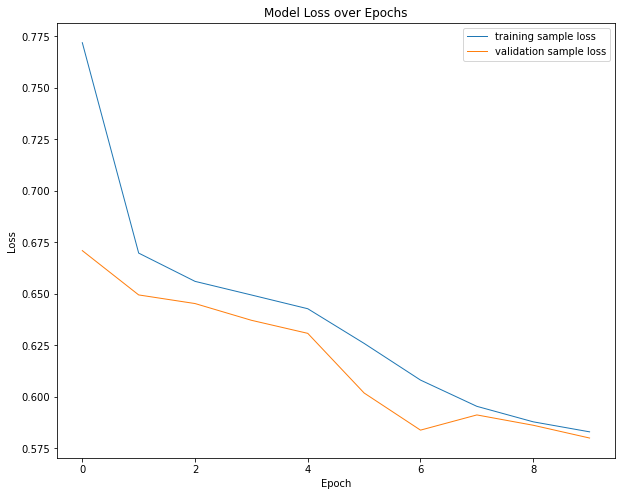

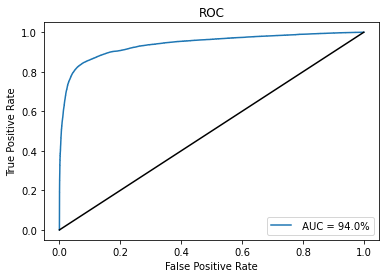

In [54]:
#sb = .7
train(49000,70000)

(96000, 12)
Train on 153600 samples, validate on 38400 samples
Epoch 1/10
153600/153600 [==============================] - 5s 35us/sample - loss: 0.8225 - tp: 35823.0000 - fp: 29152.0000 - tn: 47742.0000 - fn: 40883.0000 - accuracy: 0.5440 - precision: 0.5513 - recall: 0.4670 - auc: 0.5510 - val_loss: 0.6751 - val_tp: 9965.0000 - val_fp: 5859.0000 - val_tn: 13247.0000 - val_fn: 9329.0000 - val_accuracy: 0.6045 - val_precision: 0.6297 - val_recall: 0.5165 - val_auc: 0.6172
Epoch 2/10
153600/153600 [==============================] - 4s 25us/sample - loss: 0.6802 - tp: 34415.0000 - fp: 23066.0000 - tn: 53828.0000 - fn: 42291.0000 - accuracy: 0.5745 - precision: 0.5987 - recall: 0.4487 - auc: 0.5954 - val_loss: 0.6641 - val_tp: 9603.0000 - val_fp: 5112.0000 - val_tn: 13994.0000 - val_fn: 9691.0000 - val_accuracy: 0.6145 - val_precision: 0.6526 - val_recall: 0.4977 - val_auc: 0.6386
Epoch 3/10
153600/153600 [==============================] - 4s 25us/sample - loss: 0.6730 - tp: 35945.0000 - 

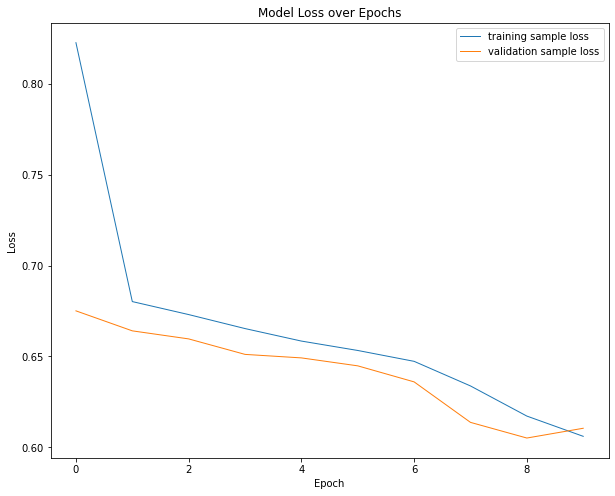

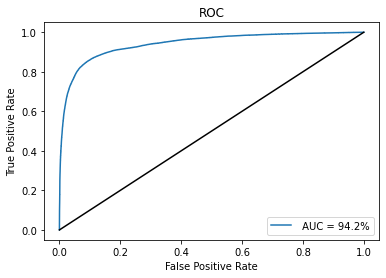

In [55]:
#sb = .6
train(36000,60000)

(105000, 12)
Train on 168000 samples, validate on 42000 samples
Epoch 1/10
168000/168000 [==============================] - 7s 40us/sample - loss: 0.8412 - tp: 39515.0000 - fp: 32301.0000 - tn: 51845.0000 - fn: 44339.0000 - accuracy: 0.5438 - precision: 0.5502 - recall: 0.4712 - auc: 0.5509 - val_loss: 0.6724 - val_tp: 12328.0000 - val_fp: 9269.0000 - val_tn: 11585.0000 - val_fn: 8818.0000 - val_accuracy: 0.5694 - val_precision: 0.5708 - val_recall: 0.5830 - val_auc: 0.6116
Epoch 2/10
168000/168000 [==============================] - 5s 28us/sample - loss: 0.6767 - tp: 36291.0000 - fp: 23788.0000 - tn: 60358.0000 - fn: 47563.0000 - accuracy: 0.5753 - precision: 0.6041 - recall: 0.4328 - auc: 0.5977 - val_loss: 0.6604 - val_tp: 9269.0000 - val_fp: 5047.0000 - val_tn: 15807.0000 - val_fn: 11877.0000 - val_accuracy: 0.5970 - val_precision: 0.6475 - val_recall: 0.4383 - val_auc: 0.6308
Epoch 3/10
168000/168000 [==============================] - 5s 28us/sample - loss: 0.6682 - tp: 35236.0000

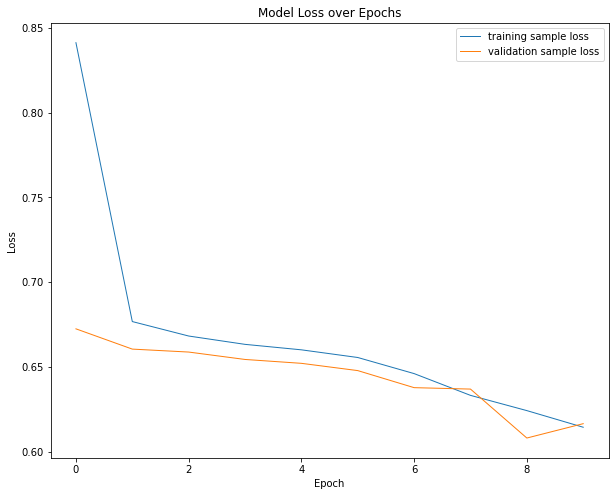

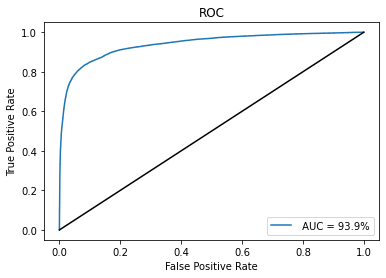

In [56]:
#sb = .5
train(35000,70000)

(112000, 12)
Train on 179200 samples, validate on 44800 samples
Epoch 1/10
179200/179200 [==============================] - 6s 34us/sample - loss: 0.7908 - tp: 37568.0000 - fp: 31854.0000 - tn: 57904.0000 - fn: 51874.0000 - accuracy: 0.5328 - precision: 0.5412 - recall: 0.4200 - auc: 0.5383 - val_loss: 0.6805 - val_tp: 10795.0000 - val_fp: 7243.0000 - val_tn: 14999.0000 - val_fn: 11763.0000 - val_accuracy: 0.5758 - val_precision: 0.5985 - val_recall: 0.4785 - val_auc: 0.5903
Epoch 2/10
179200/179200 [==============================] - 5s 26us/sample - loss: 0.6838 - tp: 36244.0000 - fp: 26234.0000 - tn: 63524.0000 - fn: 53198.0000 - accuracy: 0.5567 - precision: 0.5801 - recall: 0.4052 - auc: 0.5765 - val_loss: 0.6781 - val_tp: 10370.0000 - val_fp: 6341.0000 - val_tn: 15901.0000 - val_fn: 12188.0000 - val_accuracy: 0.5864 - val_precision: 0.6205 - val_recall: 0.4597 - val_auc: 0.6044
Epoch 3/10
179200/179200 [==============================] - 5s 26us/sample - loss: 0.6757 - tp: 39017.00

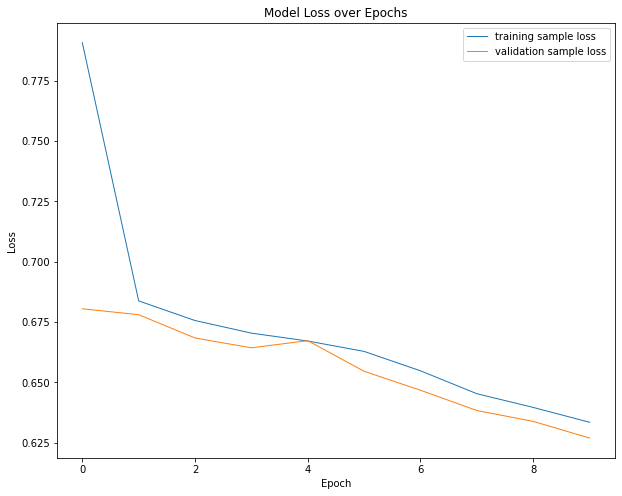

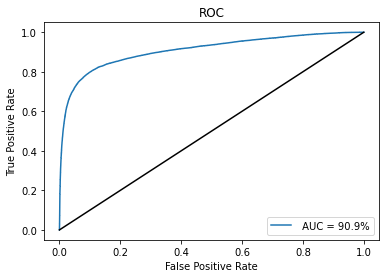

In [57]:
##sb = .4
train(32000,80000)

(104000, 12)
Train on 166400 samples, validate on 41600 samples
Epoch 1/10
166400/166400 [==============================] - 6s 35us/sample - loss: 0.7998 - tp: 38145.0000 - fp: 34393.0000 - tn: 48904.0000 - fn: 44958.0000 - accuracy: 0.5231 - precision: 0.5259 - recall: 0.4590 - auc: 0.5284 - val_loss: 0.6840 - val_tp: 11133.0000 - val_fp: 8425.0000 - val_tn: 12278.0000 - val_fn: 9764.0000 - val_accuracy: 0.5628 - val_precision: 0.5692 - val_recall: 0.5328 - val_auc: 0.5837
Epoch 2/10
166400/166400 [==============================] - 4s 26us/sample - loss: 0.6869 - tp: 34237.0000 - fp: 26780.0000 - tn: 56517.0000 - fn: 48866.0000 - accuracy: 0.5454 - precision: 0.5611 - recall: 0.4120 - auc: 0.5628 - val_loss: 0.6846 - val_tp: 10857.0000 - val_fp: 8438.0000 - val_tn: 12265.0000 - val_fn: 10040.0000 - val_accuracy: 0.5558 - val_precision: 0.5627 - val_recall: 0.5195 - val_auc: 0.5862
Epoch 3/10
166400/166400 [==============================] - 4s 26us/sample - loss: 0.6832 - tp: 36745.000

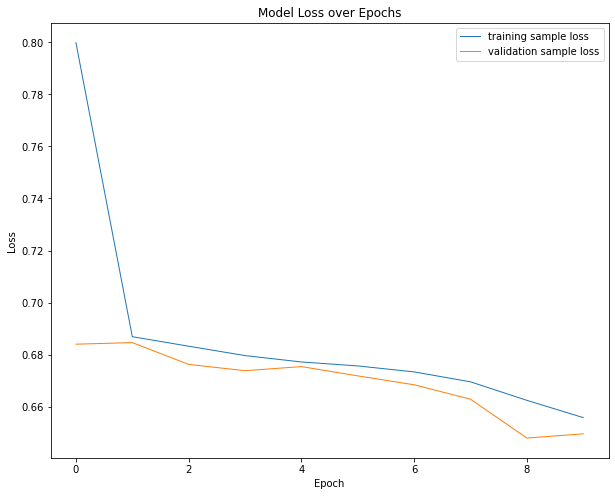

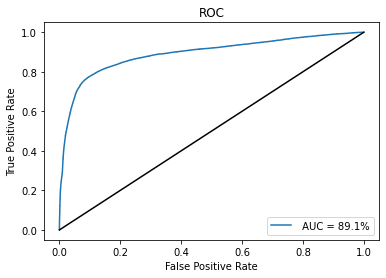

In [58]:
#sb = .3
train(24000,80000)

(96000, 12)
Train on 153600 samples, validate on 38400 samples
Epoch 1/10
153600/153600 [==============================] - 5s 35us/sample - loss: 0.8305 - tp: 40017.0000 - fp: 38439.0000 - tn: 38455.0000 - fn: 36689.0000 - accuracy: 0.5109 - precision: 0.5101 - recall: 0.5217 - auc: 0.5135 - val_loss: 0.6886 - val_tp: 5932.0000 - val_fp: 4174.0000 - val_tn: 14932.0000 - val_fn: 13362.0000 - val_accuracy: 0.5433 - val_precision: 0.5870 - val_recall: 0.3075 - val_auc: 0.5541
Epoch 2/10
153600/153600 [==============================] - 4s 26us/sample - loss: 0.6905 - tp: 36850.0000 - fp: 32450.0000 - tn: 44444.0000 - fn: 39856.0000 - accuracy: 0.5293 - precision: 0.5317 - recall: 0.4804 - auc: 0.5437 - val_loss: 0.6879 - val_tp: 15463.0000 - val_fp: 13849.0000 - val_tn: 5257.0000 - val_fn: 3831.0000 - val_accuracy: 0.5396 - val_precision: 0.5275 - val_recall: 0.8014 - val_auc: 0.5740
Epoch 3/10
153600/153600 [==============================] - 4s 26us/sample - loss: 0.6869 - tp: 40180.0000 

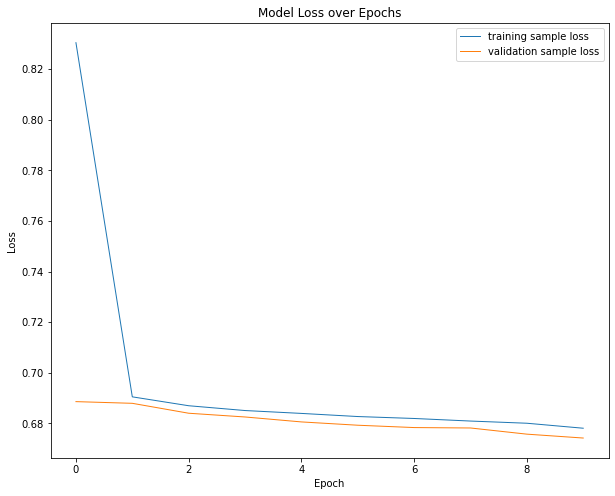

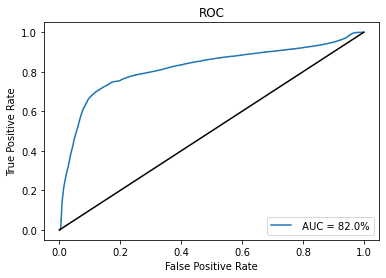

In [59]:
#sb = .2
train(16000,80000)

(99000, 12)
Train on 158400 samples, validate on 39600 samples
Epoch 1/10
158400/158400 [==============================] - 6s 38us/sample - loss: 0.8700 - tp: 40411.0000 - fp: 39455.0000 - tn: 39976.0000 - fn: 38558.0000 - accuracy: 0.5075 - precision: 0.5060 - recall: 0.5117 - auc: 0.5086 - val_loss: 0.6904 - val_tp: 14541.0000 - val_fp: 13105.0000 - val_tn: 6464.0000 - val_fn: 5490.0000 - val_accuracy: 0.5304 - val_precision: 0.5260 - val_recall: 0.7259 - val_auc: 0.5576
Epoch 2/10
158400/158400 [==============================] - 4s 28us/sample - loss: 0.6924 - tp: 44918.0000 - fp: 41785.0000 - tn: 37646.0000 - fn: 34051.0000 - accuracy: 0.5212 - precision: 0.5181 - recall: 0.5688 - auc: 0.5301 - val_loss: 0.6891 - val_tp: 14817.0000 - val_fp: 13437.0000 - val_tn: 6132.0000 - val_fn: 5214.0000 - val_accuracy: 0.5290 - val_precision: 0.5244 - val_recall: 0.7397 - val_auc: 0.5576
Epoch 3/10
158400/158400 [==============================] - 4s 28us/sample - loss: 0.6910 - tp: 45269.0000 

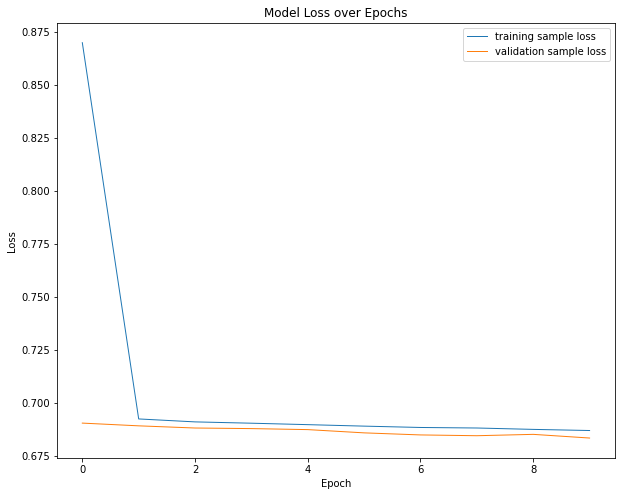

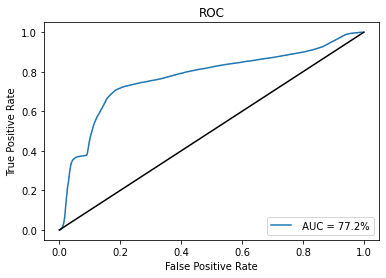

In [60]:
#sb = .1
train(9000,90000)

(102000, 12)
Train on 163200 samples, validate on 40800 samples
Epoch 1/10
163200/163200 [==============================] - 6s 38us/sample - loss: 0.8442 - tp: 47528.0000 - fp: 45358.0000 - tn: 36460.0000 - fn: 33854.0000 - accuracy: 0.5146 - precision: 0.5117 - recall: 0.5840 - auc: 0.5137 - val_loss: 0.6901 - val_tp: 16672.0000 - val_fp: 15251.0000 - val_tn: 4931.0000 - val_fn: 3946.0000 - val_accuracy: 0.5295 - val_precision: 0.5223 - val_recall: 0.8086 - val_auc: 0.5433
Epoch 2/10
163200/163200 [==============================] - 4s 26us/sample - loss: 0.6915 - tp: 52007.0000 - fp: 47641.0000 - tn: 34177.0000 - fn: 29375.0000 - accuracy: 0.5281 - precision: 0.5219 - recall: 0.6390 - auc: 0.5387 - val_loss: 0.6881 - val_tp: 13900.0000 - val_fp: 12182.0000 - val_tn: 8000.0000 - val_fn: 6718.0000 - val_accuracy: 0.5368 - val_precision: 0.5329 - val_recall: 0.6742 - val_auc: 0.5572
Epoch 3/10
163200/163200 [==============================] - 4s 26us/sample - loss: 0.6899 - tp: 52261.0000

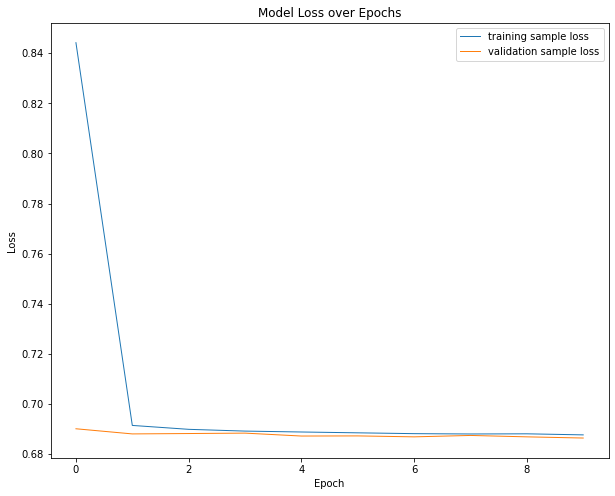

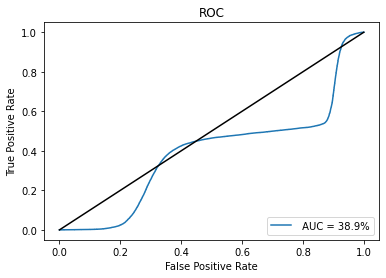

In [61]:
#sb = .01
train(1000,101000)

In [65]:
auc_list

[0.9328258748000001,
 0.9299664524666668,
 0.9268746796666667,
 0.9397099110000001,
 0.9416147596,
 0.9392507365999998,
 0.9085425056666667,
 0.8910814105333332,
 0.8198343026,
 0.7720593074000001,
 0.38931328339999993]

In [68]:
sb_ratio = [1,0.9,.8,.7,.6,.5,.4,.3,.2,.1,.01]

Text(0, 0.5, 'AUC')

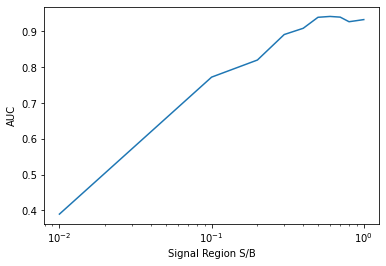

In [71]:
plt.plot(sb_ratio,auc_list)
plt.xlabel('Signal Region S/B')
plt.xscale('log')
plt.ylabel('AUC')

In [74]:

eff_ratio_4c = []
for i in range(len(tpr_list)):
    tpr_list[i] = tpr_list[i] + 0.0000001
    fpr_list[i] = fpr_list[i] + 0.0000001
    eff_ratio_4c.append(max(tpr_list[i]/np.sqrt(fpr_list[i])))   #* (sb_ratio[i] * np_bg_SR.shape[0])/(np.sqrt(np_bg_SR.shape[0])))
    

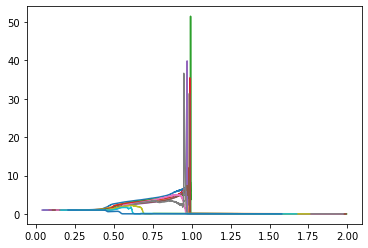

In [90]:
for i in range(len(threshold_list)):
    plt.plot(threshold_list[i],tpr_list[i]/np.sqrt(fpr_list[i]))